# Datensatz herunterladen
Link: https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import keras
import tensorflow as tf
import os
import random
warnings.filterwarnings('ignore')


# Korrupte Bilder herausfiltern
Bei der Arbeit mit vielen realen Bilddaten sind beschädigte Bilder ein häufiges Phänomen -> Schlecht kodierte Bilder herausfiltern, die nicht die Zeichenfolge "JFIF" in ihrem Header enthalten.

In [25]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


# Dataframe erstellen

In [26]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
  for path in os.listdir("PetImages/"+class_name):
    if class_name == 'Cat':
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages\Cat\0.jpg 0


In [27]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

images  label
0  PetImages\Dog\6371.jpg      1
1   PetImages\Cat\989.jpg      0
2  PetImages\Cat\5343.jpg      0
3  PetImages\Cat\6138.jpg      0
4    PetImages\Dog\94.jpg      1

In [28]:
for i in df['images']:
  if '.jpg' not in i:
    print(i)

PetImages\Dog\Thumbs.db
PetImages\Cat\Thumbs.db


In [29]:
# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
len(df)

23424

# Datenanalyse

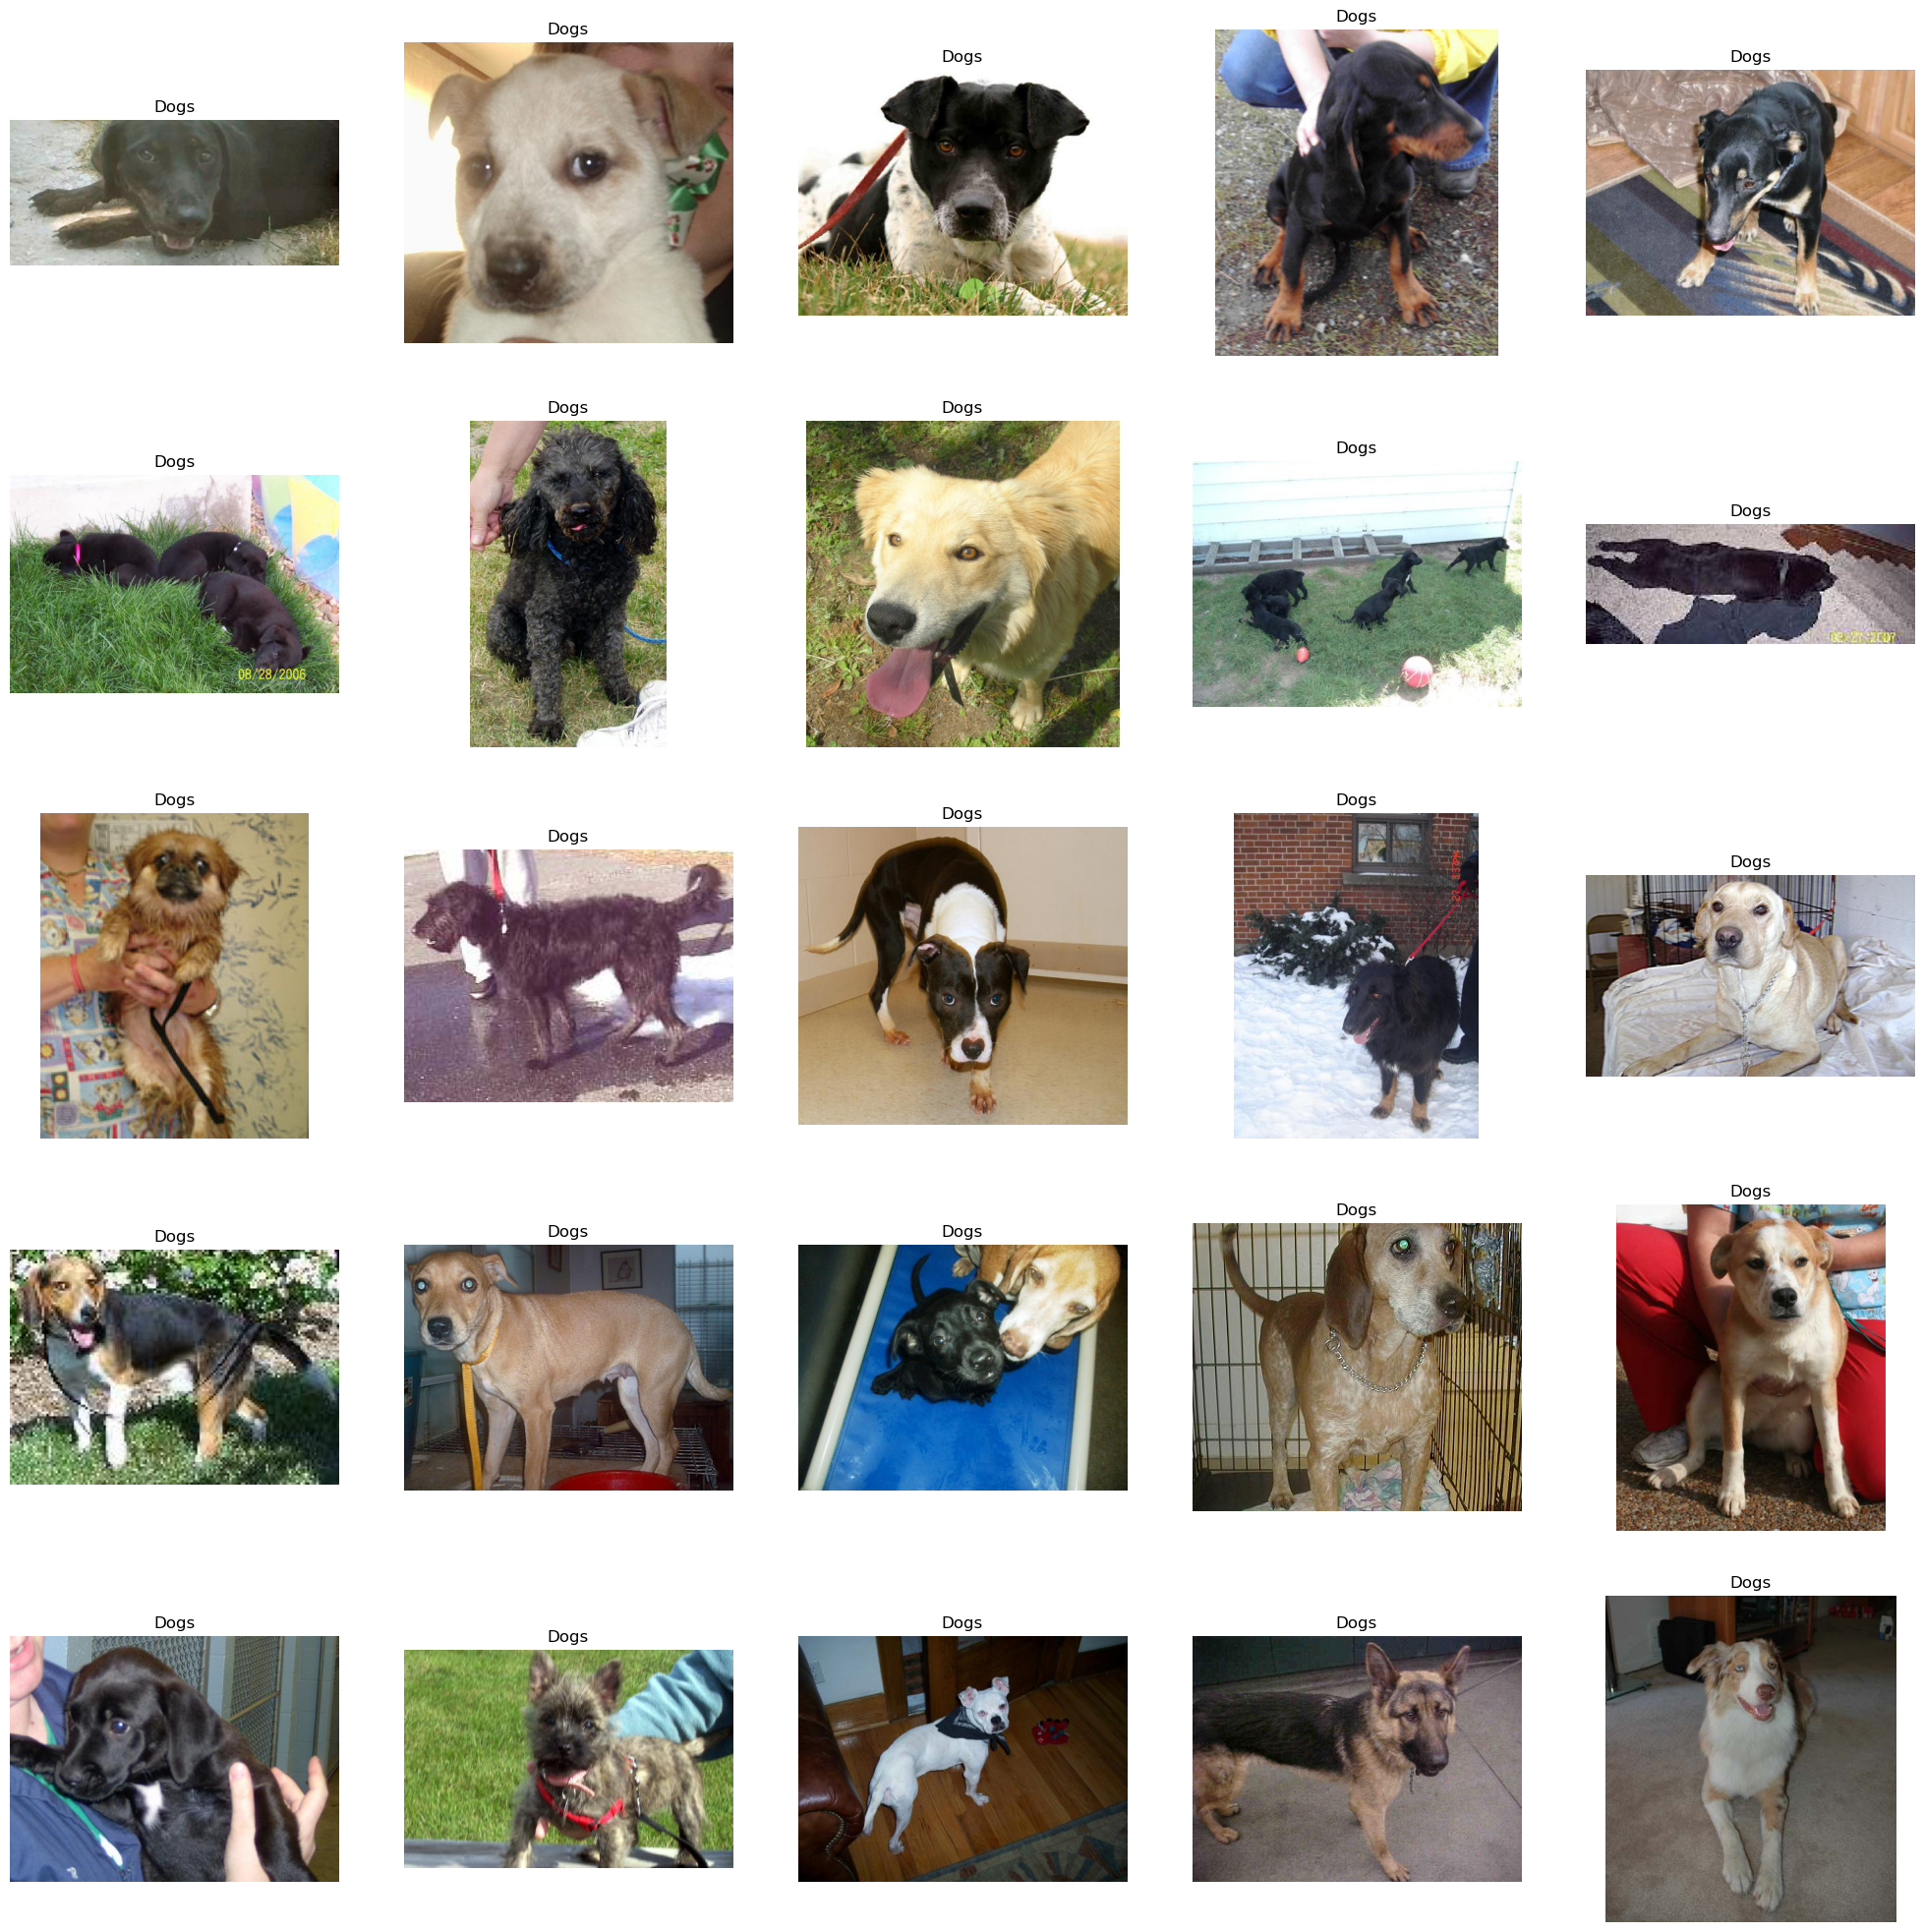

In [30]:
# display grid of images
plt.figure(figsize=(25, 25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for i, file in enumerate(files):
  plt.subplot(5, 5, i+1)
  img = plt.imread(file)
  plt.imshow(img)
  plt.title("Dogs")
  plt.axis('off')

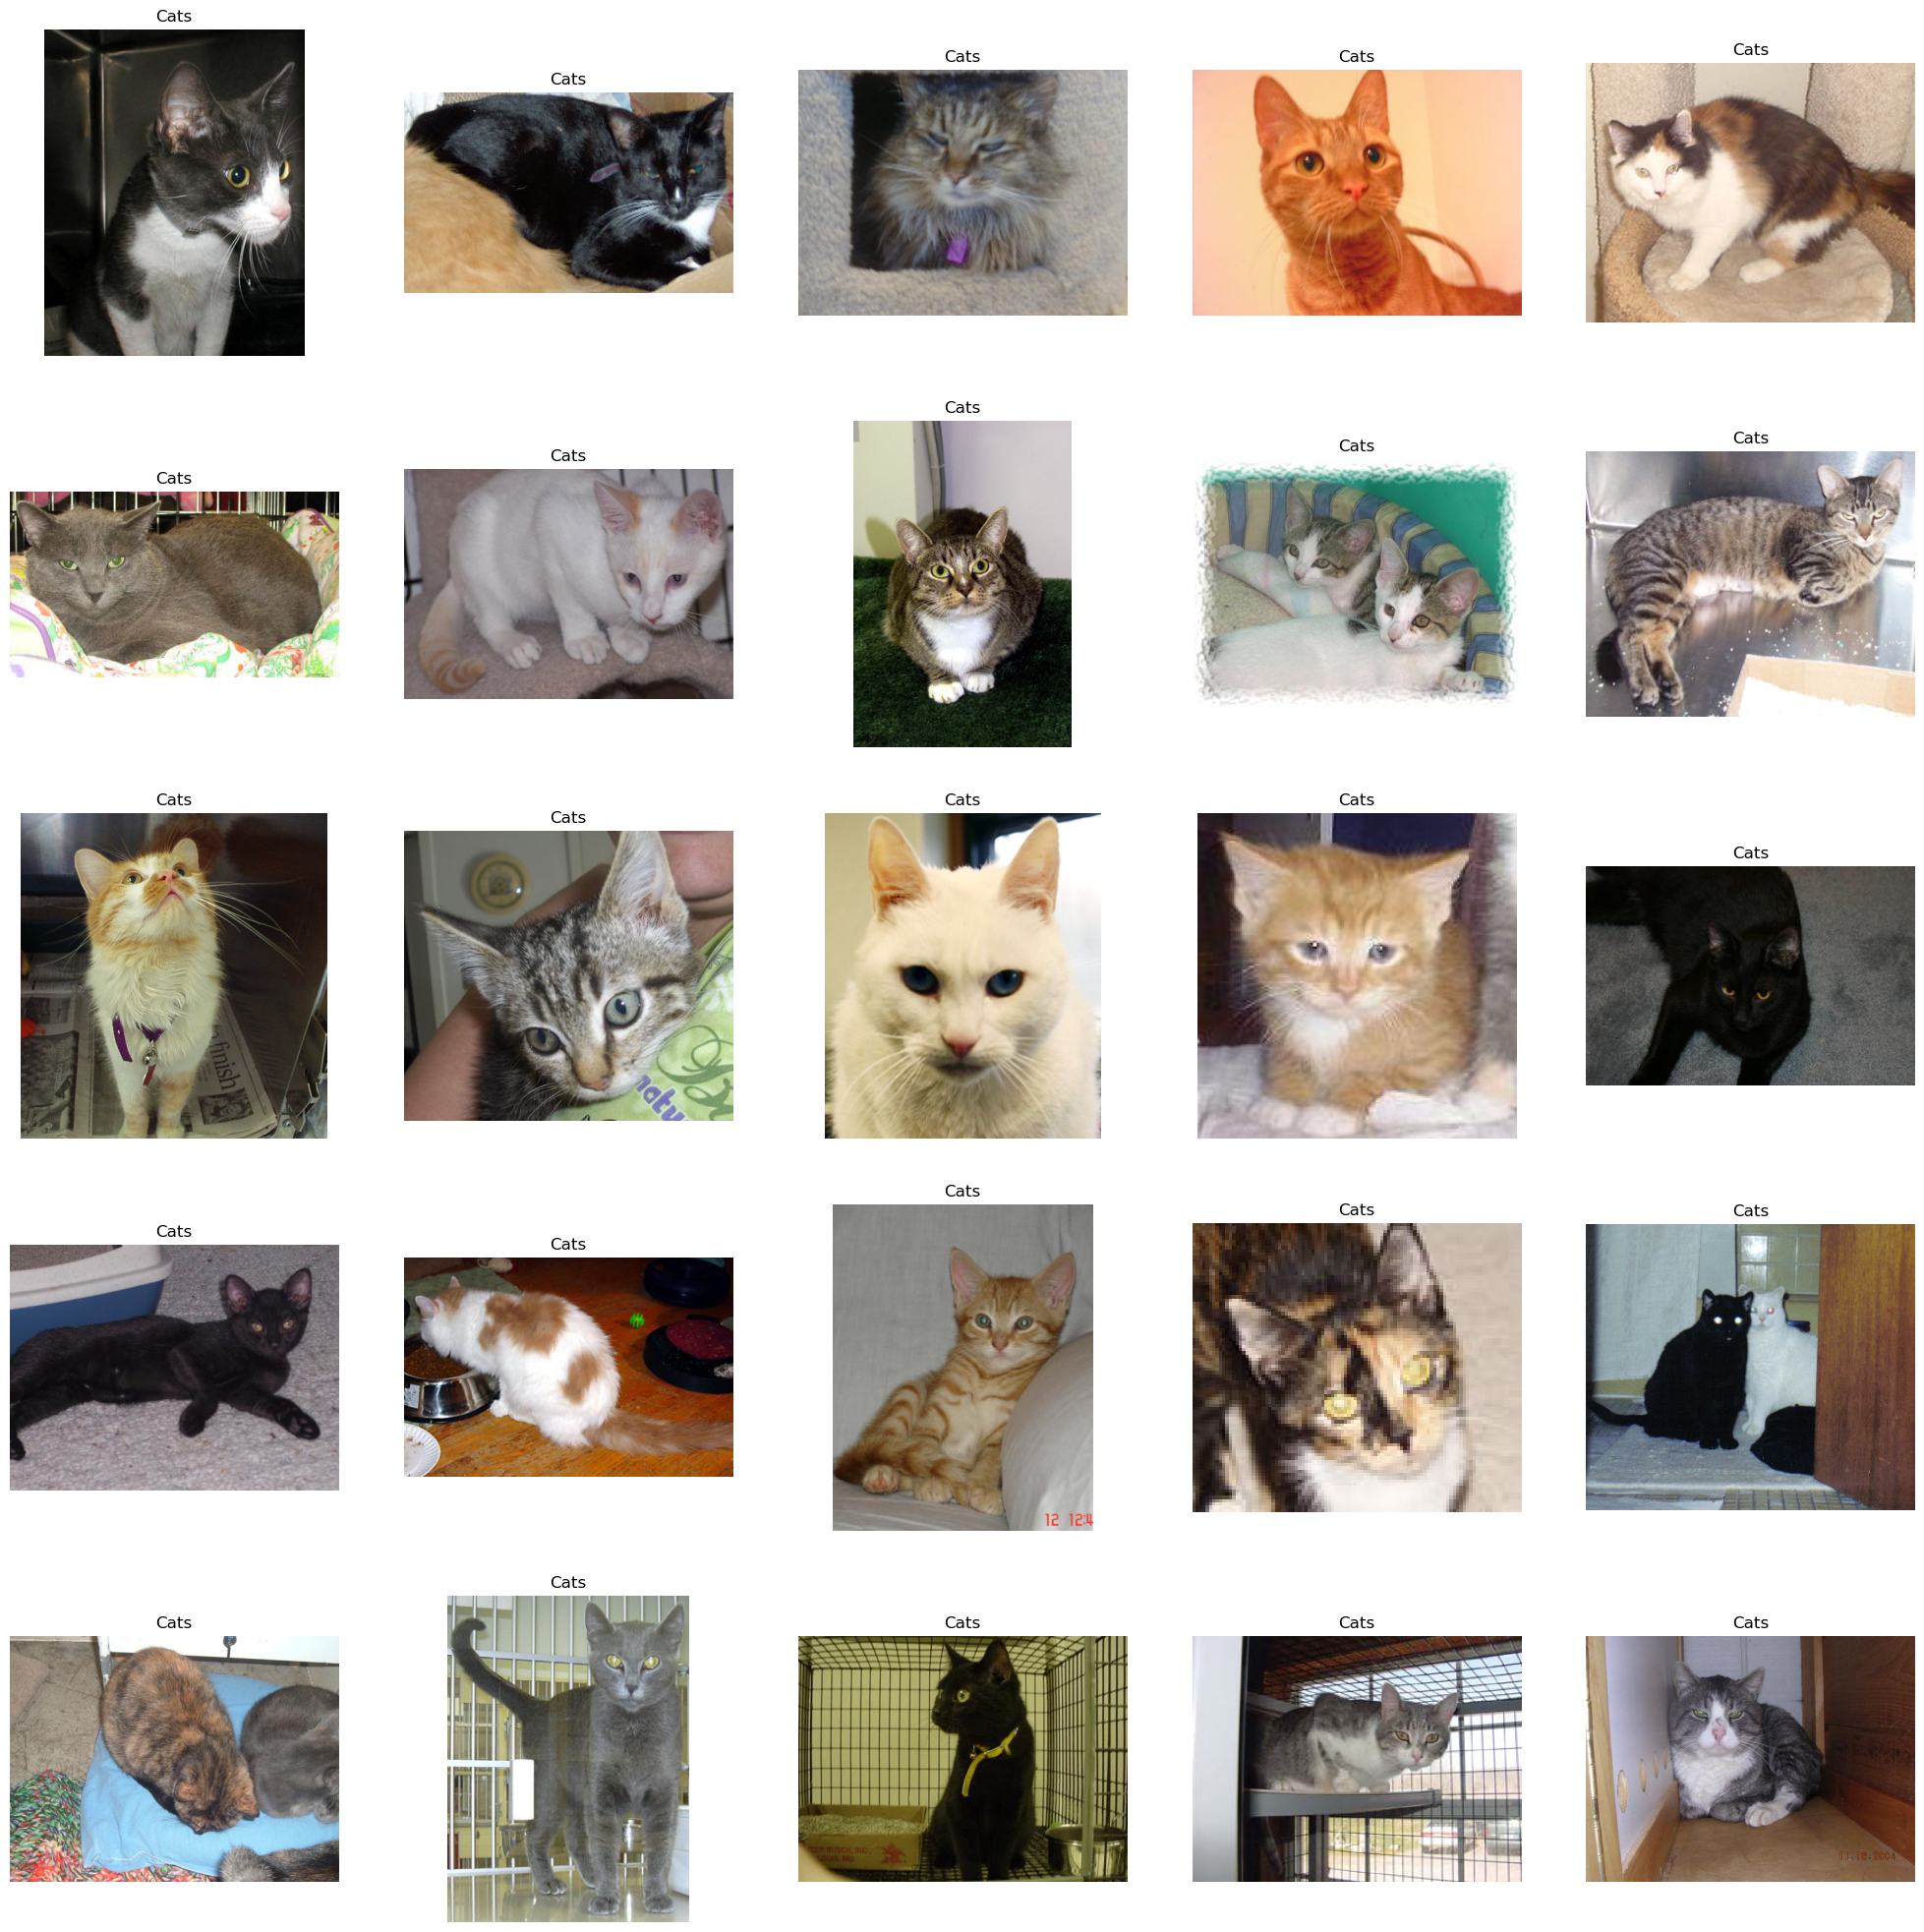

In [31]:
# display grid of images
plt.figure(figsize=(25, 25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for i, file in enumerate(files):
  plt.subplot(5, 5, i+1)
  img = plt.imread(file)
  plt.imshow(img)
  plt.title("Cats")
  plt.axis('off')

In [32]:
df['label'].value_counts()

label
0    11749
1    11675
Name: count, dtype: int64

# Create DataGenerator for the Images

In [33]:
df['label'] = df['label'].astype('str')

In [34]:
df.head()

images label
0  PetImages\Dog\6371.jpg     1
1   PetImages\Cat\989.jpg     0
2  PetImages\Cat\5343.jpg     0
3  PetImages\Cat\6138.jpg     0
4    PetImages\Dog\94.jpg     1

In [35]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [36]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # Normalisierung der Pixelwerte
    rotation_range = 40, # Augmentation: zufällige Rotation der Bilder
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest' # neu entstandene pixel werden mit den nächsten pixeln gefüllt
)

val_generator = ImageDataGenerator(rescale = 1./255) # Für Test nur Pixelwerte skalieren

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', # Spalte mit den Bildpfaden
    y_col='label', # Spalte mit den Labels
    target_size=(128,128), # Größe der Bilder
    batch_size=512, # Anzahl der Bilder, die pro Iteration verarbeitet werden
    class_mode='binary' # binäre Klassifikationsaufgabe
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

Found 18737 validated image filenames belonging to 2 classes.
Found 4685 validated image filenames belonging to 2 classes.


# Model erstellen (CNN Netzwerk)

In [37]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([                                                                # Lineares Stapelmodell von Schichten
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),  # 16 Filter mit 3x3 Kernel, relu Aktivierungsfunktion, 128x128 mit 3 Farbkanälen
                    MaxPool2D((2,2)),                                               # MaxPooling mit 2x2 Kernel um Rechenlast zu verringern und wichtigsten Merkmale hervorzuheben
                    Conv2D(32, (3,3), activation='relu'),                           # Noch zwei mal wiederholen und Filter verdoppeln
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),                                                      # Daten in ein eindimensionales Array umwandeln
                    Dense(512, activation='relu'),                                  # Dense Layer mit 512 Neuronen
                    Dense(1, activation='sigmoid')                                  # Ausgabelayer mit einem Neuron -> binäre Klassifikation
])

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Adam Optimizer, binäre Kreuzentropie als Loss Funktion, Accuracy als Metrik
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)      

In [39]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
37/37 [==============================] - 140s 4s/step - loss: 0.7306 - accuracy: 0.5325 - val_loss: 0.6816 - val_accuracy: 0.5306
Epoch 2/10
37/37 [==============================] - 137s 4s/step - loss: 0.6524 - accuracy: 0.6181 - val_loss: 0.6482 - val_accuracy: 0.6102
Epoch 3/10
37/37 [==============================] - 133s 4s/step - loss: 0.5966 - accuracy: 0.6865 - val_loss: 0.5706 - val_accuracy: 0.7084
Epoch 4/10
37/37 [==============================] - 350s 10s/step - loss: 0.5684 - accuracy: 0.7084 - val_loss: 0.5907 - val_accuracy: 0.6753
Epoch 5/10
33/37 [=========================>....] - ETA: 20s - loss: 0.5550 - accuracy: 0.7201

KeyboardInterrupt: 

In [ ]:
model.save("catvsdogs.h5py") # Speichern des Modells

INFO:tensorflow:Assets written to: catvsdogs.h5py\assets


INFO:tensorflow:Assets written to: catvsdogs.h5py\assets


In [ ]:
#from keras.models import load_model
#model = load_model('catvsdogs.h5py') # Modell laden

# Visualisierung der Ergebnisse

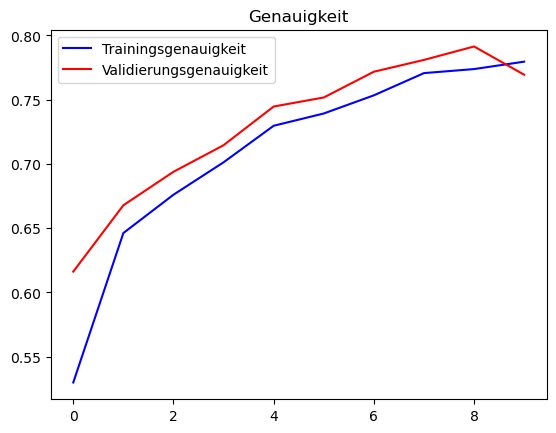

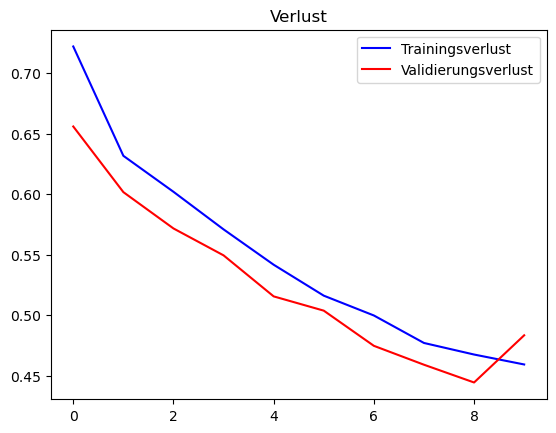

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Trainingsgenauigkeit')
plt.plot(epochs, val_acc, 'r', label='Validierungsgenauigkeit')
plt.title('Genauigkeit')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Trainingsverlust')
plt.plot(epochs, val_loss, 'r', label='Validierungsverlust')
plt.title('Verlust')
plt.legend()
plt.show()

# Echtes Bild testen

1/1 [==============================] - 0s 25ms/step
Dog


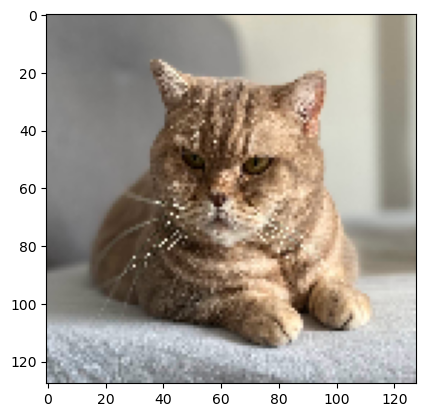

In [ ]:

image_path = "katze.jpg" # path of the image
img = keras.utils.load_img(image_path, target_size=(128, 128))
plt.imshow(img)

img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)

1/1 [==============================] - 0s 18ms/step
Dog


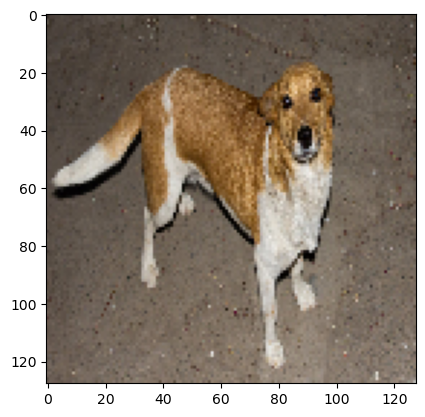

In [ ]:
image_path = "hund.jpg" # path of the image
img = keras.utils.load_img(image_path, target_size=(128, 128))
plt.imshow(img)

img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)